In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '167393'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

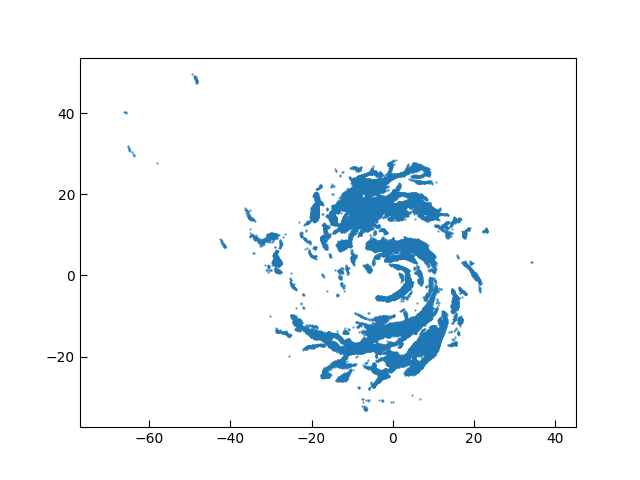

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


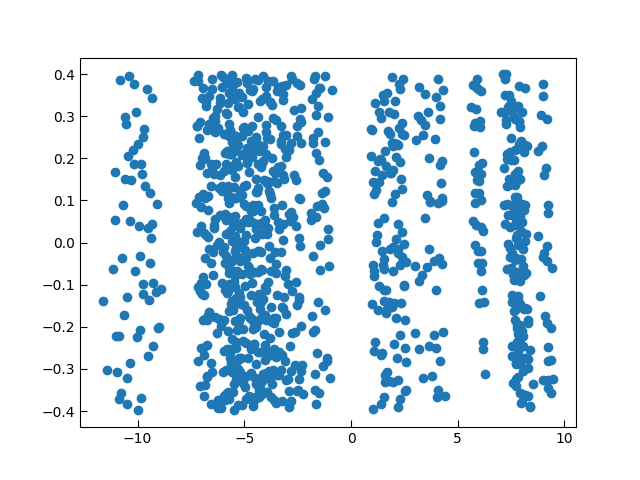

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


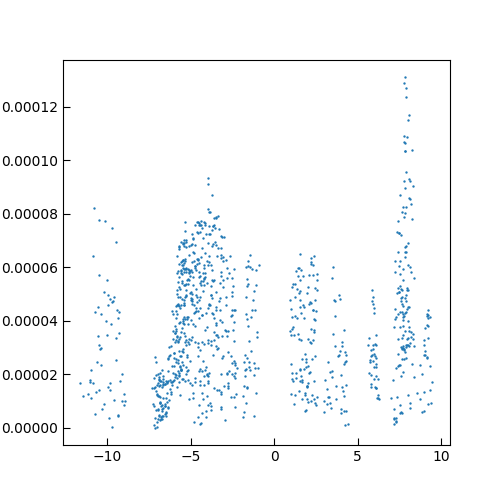

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [6]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

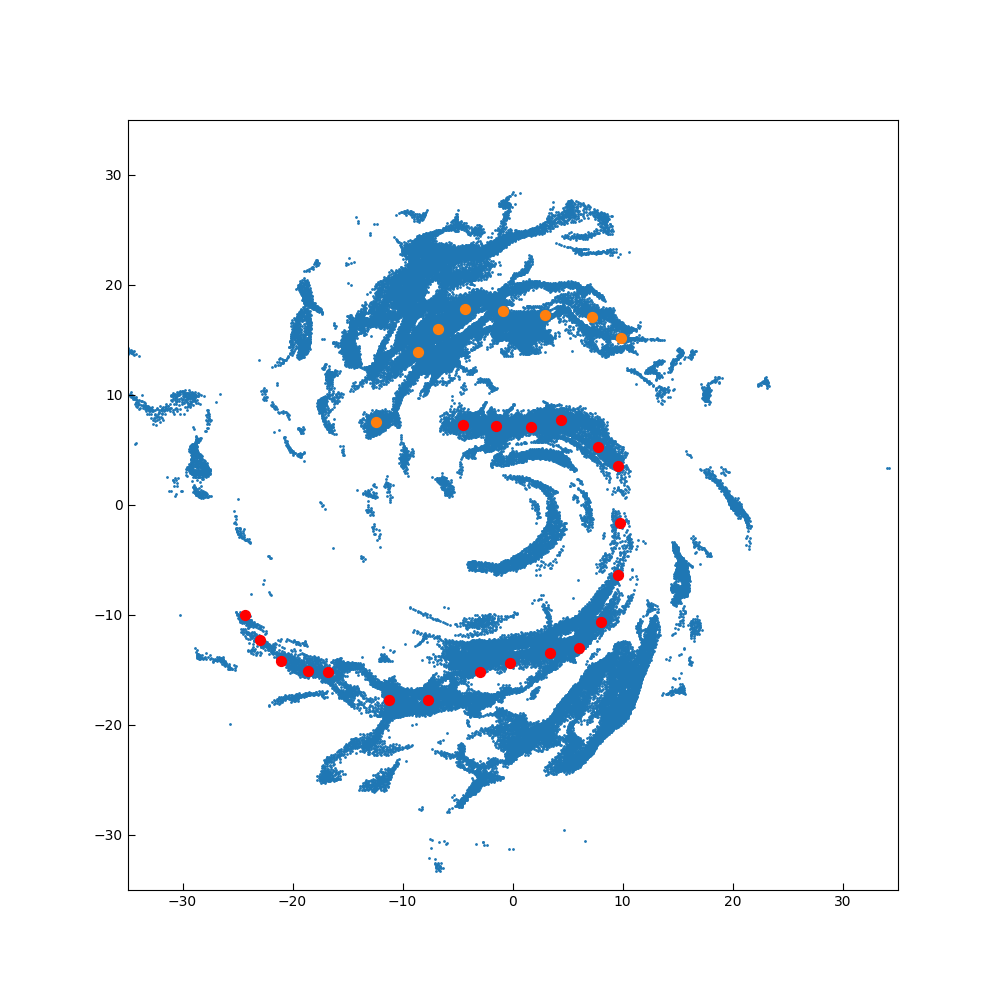

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 35
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [12]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [13]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [14]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [15]:
b = 0.3

In [16]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

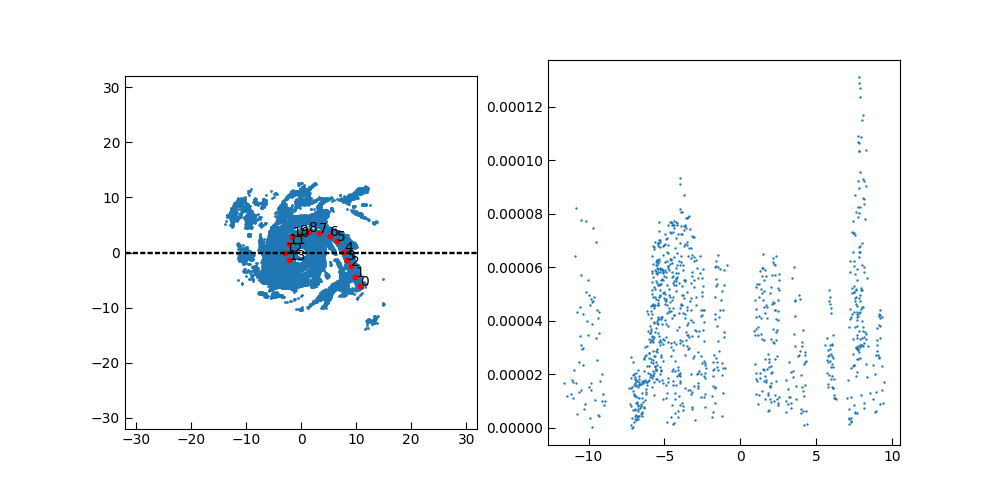

In [17]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 32
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

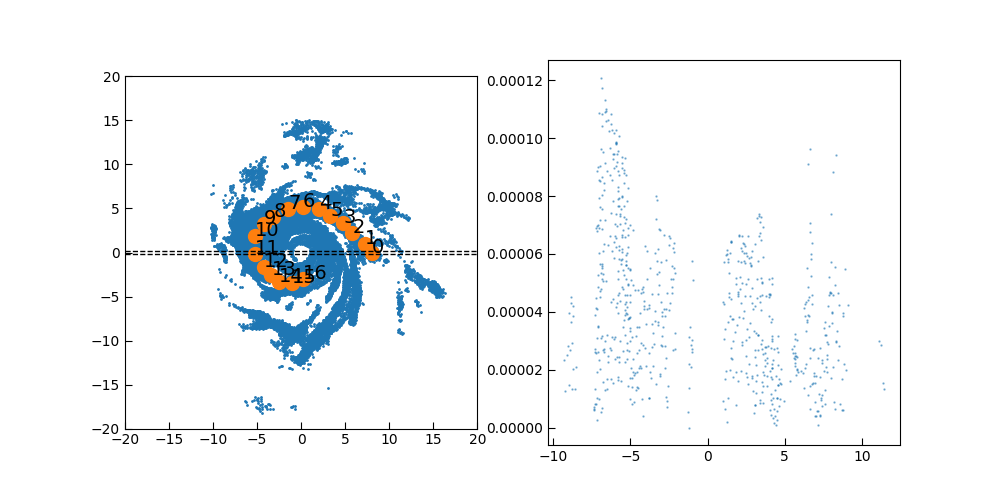

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [19]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [20]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [21]:
arm = df_arm2.copy(deep=True)

In [22]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,3.917749,7.007576,2,0,"({'x_rot': [0.14805481216968486, 0.44479595398...","{'x_rot': [0.14805481216968486, 0.444795953981...",1.061014,"{'x_rot': [8.02837932466362, 7.207188682960902...","{'x_rot': 8.02837932466362, 'y_rot': 8.8817841...","{'x_band': [-0.922078590690061, 1.081050787136..."
1,2.647908,6.776696,2,1,"({'x_rot': [0.2863121203505381, 0.555734181643...","{'x_rot': [0.2863121203505381, 0.5557341816434...",1.198300,"{'x_rot': [7.952840027439798, 7.27564548156264...","{'x_rot': 7.275645481562648, 'y_rot': -4.44089...","{'x_band': [1.129490767397529, 1.1108402852285..."
2,0.916306,6.141775,2,2,"({'x_rot': [0.49954979607416017, 0.71367660388...","{'x_rot': [0.49954979607416017, 0.713676603889...",1.422696,"{'x_rot': [7.508965269756267, 7.09323568416377...","{'x_rot': 6.209751633800959, 'y_rot': 5.551115...","{'x_band': [1.0546132299064022, 1.156805261129..."
3,-0.584416,5.795455,2,3,"({'x_rot': [0.706130484222967, 0.8465958937639...","{'x_rot': [0.706130484222967, 0.84659589376390...",1.671297,"{'x_rot': [6.579142345034529, 6.47683220323837...","{'x_rot': 5.824846346792121, 'y_rot': 1.221245...","{'x_band': [0.9342313559434001, 1.045587757276..."
4,-3.297258,4.179293,2,4,"({'x_rot': [0.999314183401947, 0.9474152995704...","{'x_rot': [0.999314183401947, 0.94741529957041...",2.238764,"{'x_rot': [3.0749023889149694, 3.6801714114799...","{'x_rot': 5.323382540046932, 'y_rot': 0.0}","{'x_band': [0.999314183401947, 0.9474152995704..."
5,-1.969697,4.871934,2,5,"({'x_rot': [0.888220574602408, 0.9343587475873...","{'x_rot': [0.888220574602408, 0.93435874758737...",1.955000,"{'x_rot': [5.028252257397819, 5.29016641835401...","{'x_rot': 5.255039806600962, 'y_rot': 1.110223...","{'x_band': [0.9343587475873775, 0.960511440919..."
6,-4.451659,2.736291,2,6,"({'x_rot': [1.0256672767038522, 0.858869962964...","{'x_rot': [1.0256672767038522, 0.8588699629649...",2.590458,"{'x_rot': [0.33189680742488603, 1.292812249179...","{'x_rot': 5.225376825789713, 'y_rot': -4.44089...","{'x_band': [1.0256672767038522, 1.020576245254..."
7,-5.086580,1.120130,2,7,"({'x_rot': [0.934155593806681, 0.6768623358677...","{'x_rot': [0.934155593806681, 0.67686233586779...",2.924839,"{'x_rot': [-2.319027845165108, -1.128552885847...","{'x_rot': 5.208453503982754, 'y_rot': 0.0}","{'x_band': [0.9408852737705736, 1.036903114204..."
8,-5.086580,-0.784632,2,8,"({'x_rot': [0.7132425232139373, 0.389373392781...","{'x_rot': [0.7132425232139373, 0.3893733927817...",3.294642,"{'x_rot': [-4.940274115330374, -3.650078017379...","{'x_rot': 5.14674114435182, 'y_rot': 1.6653345...","{'x_band': [0.9335109204588288, 1.037279896107..."
9,-4.913420,-2.054473,2,9,"({'x_rot': [0.5131270094103779, 0.169027183246...","{'x_rot': [0.5131270094103779, 0.1690271832462...",3.537634,"{'x_rot': [-6.317804999602107, -5.057188977116...","{'x_rot': 5.325650739992701, 'y_rot': 0.0}","{'x_band': [0.9714954878109561, 1.045393274815..."


(-2.5, 2.5)

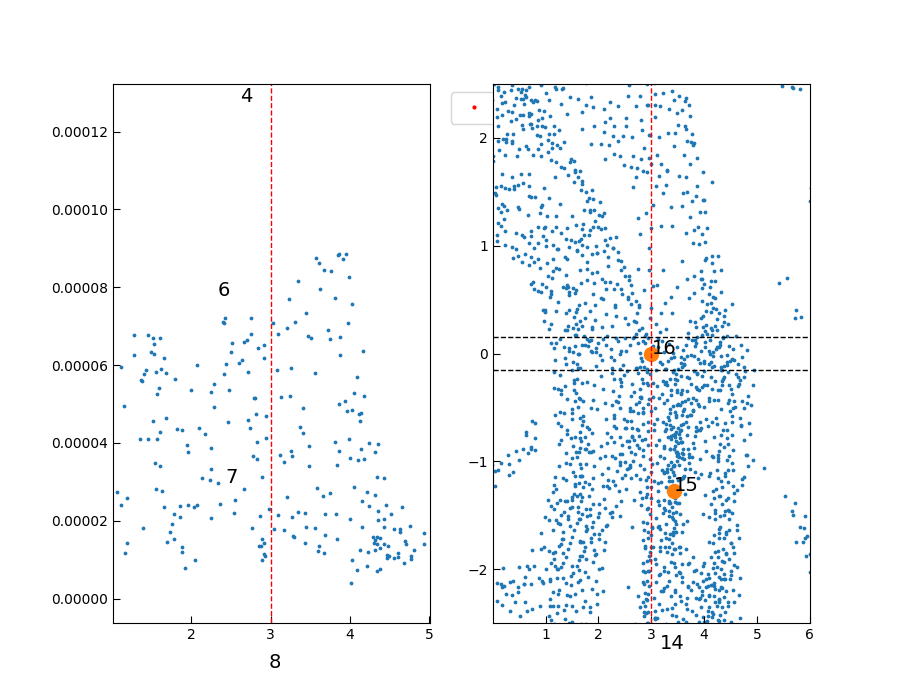

In [186]:
%matplotlib widget

n= 16 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(9,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [187]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [188]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(2.0061451739124465e-08, 6.675800727275958e-05)

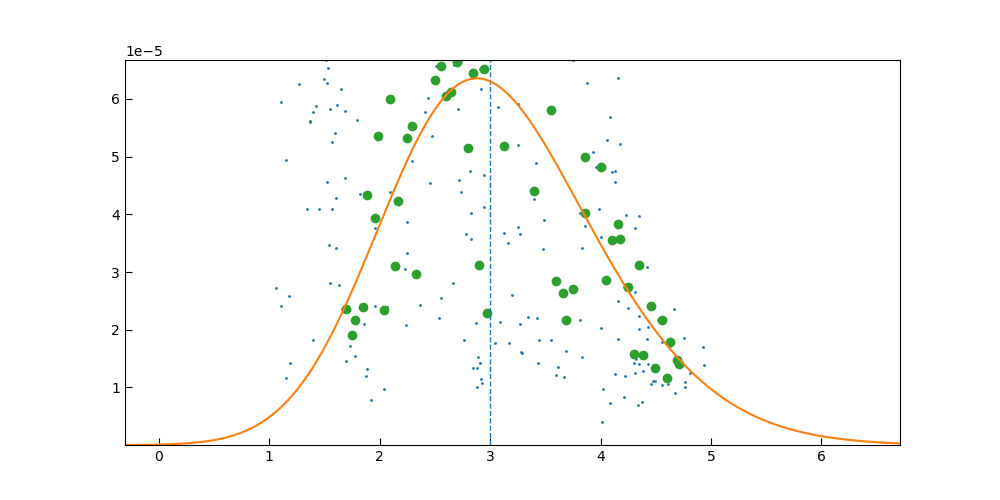

In [189]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [190]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [191]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000064,7.595637,0.05,False,1.222636,0.0,0.716529,0.000009,0.542666,2.791414,0.523856,"[6.952128017645478, 7.0356368493555665, 7.1370...",3.917749,"[8.758426699397312e-06, 1.78844827032675e-05, ...",7.007576
1,0.000238,5.934664,0.05,False,4.086983,1.0,1.765205,0.000023,0.075682,1.605188,0.301171,"[5.4803802539965085, 5.561102297182331, 5.6172...",2.647908,"[2.7939000447671148e-05, 2.8216246648892136e-0...",6.776696
2,0.000104,6.707008,0.05,False,-2.949261,2.0,0.822144,0.000009,0.064025,1.893338,0.136013,"[5.231148932991507, 5.320778077017274, 5.41826...",0.916306,"[3.117555804778559e-05, 2.755359067852062e-05,...",6.141775
3,0.000099,6.518918,0.05,False,-3.568668,3.0,0.873576,0.000006,0.042635,1.502056,0.093262,"[4.812580997283398, 4.891404446637681, 4.94968...",-0.584416,"[1.0154422903402515e-05, 3.795455495521651e-05...",5.795455
4,0.000145,5.394204,0.05,False,0.001973,4.0,0.713167,0.000016,159024.633764,279469.836828,256.476106,"[3.9151975653785476, 3.9489480882267736, 4.021...",-3.297258,"[1.3092771184989704e-05, 1.9691212650424855e-0...",4.179293
5,0.000100,5.493339,0.05,False,0.005996,5.0,0.576389,0.000007,34430.033973,74867.083169,97.408941,"[4.455203856811665, 4.547115035863345, 4.59022...",-1.969697,"[1.1106804194044702e-05, 1.2345794156933247e-0...",4.871934
6,0.000141,5.951796,0.05,False,-2.049109,6.0,0.858396,0.000004,0.048415,0.496761,0.081308,"[4.6097408036645, 4.654513397653512, 4.6953527...",-4.451659,"[5.088054530122393e-05, 4.80057649398868e-05, ...",2.736291
7,0.000255,6.558943,0.05,False,-8.089708,7.0,2.306034,0.000018,0.057667,2.885363,0.239814,"[3.4843185548957694, 3.622638547507033, 3.7142...",-5.086580,"[1.4044969453325346e-05, 2.303054526120762e-05...",1.120130
8,0.000333,6.343969,0.05,False,-7.319570,8.0,3.450505,0.000038,0.062925,2.459983,0.552887,"[3.256863307991244, 3.314467765360805, 3.38309...",-5.086580,"[2.503399309815116e-05, 2.971127272968622e-05,...",-0.784632
9,0.000109,6.559235,0.05,False,-2.099326,9.0,0.932904,0.000004,0.057134,0.617611,0.084504,"[4.724062826045483, 4.785606565078119, 4.82648...",-4.913420,"[1.7681473196005e-05, 7.04435124164783e-06, 2....",-2.054473


In [192]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [193]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



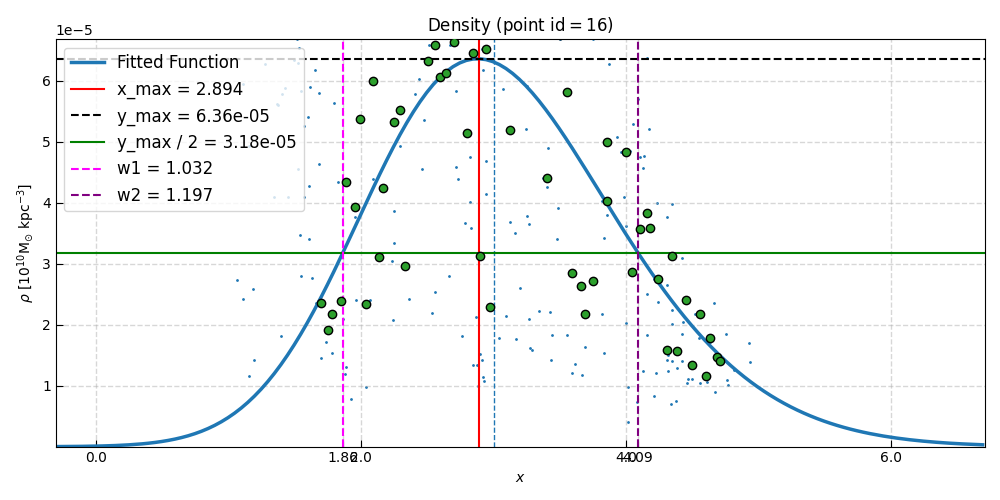

In [194]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

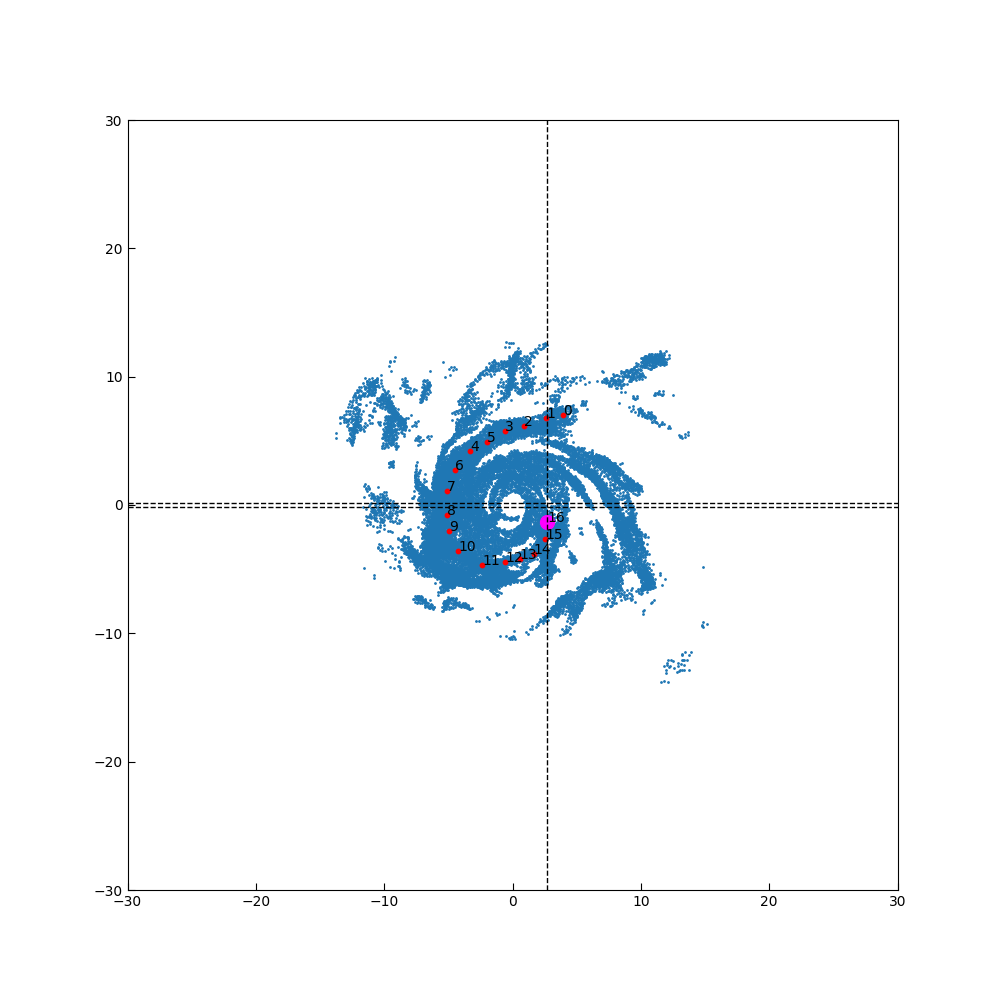

In [196]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 30
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [197]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [198]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

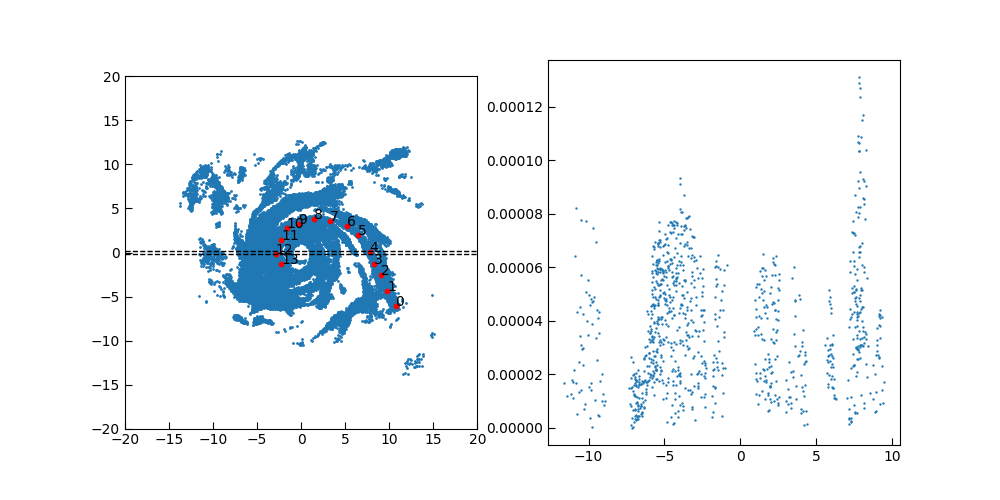

In [199]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [200]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [201]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,10.728716,-6.094877,1,0,"({'x_rot': [-1.0214082284766672, -0.8442251288...","{'x_rot': [-1.0214082284766672, -0.84422512888...",5.766559,"{'x_rot': [12.339079018982389, 10.680762900673...","{'x_rot': 12.339079018982389, 'y_rot': 7.99360...","{'x_band': [-1.0214082284766672, -0.9475601715..."
1,9.805195,-4.363276,1,1,"({'x_rot': [-1.002718999691497, -0.79724917819...","{'x_rot': [-1.002718999691497, -0.797249178197...",5.864500,"{'x_rot': [12.279945700708703, 10.732195453178...","{'x_rot': 10.732195453178484, 'y_rot': 4.44089...","{'x_band': [-1.002718999691497, -0.95480717712..."
2,9.112554,-2.516234,1,2,"({'x_rot': [-0.9558365094760144, -0.7111288518...","{'x_rot': [-0.9558365094760144, -0.71112885186...",6.013770,"{'x_rot': [11.963954616888598, 10.612852041771...","{'x_rot': 9.45357471121702, 'y_rot': 3.5527136...","{'x_band': [-0.9482521674236224, -1.0476526694..."
3,8.304473,-1.304113,1,3,"({'x_rot': [-0.9058143276901378, -0.6348392193...","{'x_rot': [-0.9058143276901378, -0.63483921938...",6.127420,"{'x_rot': [11.544359919086153, 10.363385987746...","{'x_rot': 8.406246868758005, 'y_rot': 5.995204...","{'x_band': [-0.9290953066840955, -1.0208636198..."
4,7.784993,0.023449,1,4,"({'x_rot': [-0.8165316037184779, -0.5147797839...","{'x_rot': [-0.8165316037184779, -0.51477978396...",0.003012,"{'x_rot': [10.710309080246304, 9.7920079901953...","{'x_rot': 7.7850280993305345, 'y_rot': -3.4694...","{'x_band': [-1.0410975556462745, -1.0580129487..."
5,6.457431,2.043651,1,5,"({'x_rot': [-0.5910406820508021, -0.2520806400...","{'x_rot': [-0.5910406820508021, -0.25208064003...",0.306507,"{'x_rot': [8.38967637298565, 8.031674483925203...","{'x_rot': 6.773103394590616, 'y_rot': 2.220446...","{'x_band': [-0.9640944489936147, -1.0092692539..."
6,5.187590,2.967172,1,6,"({'x_rot': [-0.39903075047108366, -0.052369596...","{'x_rot': [-0.39903075047108366, -0.0523695968...",0.519558,"{'x_rot': [6.286856185622935, 6.34493832272951...","{'x_rot': 5.976219536928488, 'y_rot': 0.0}","{'x_band': [-0.9689300818382802, -0.9281594795..."
7,3.225108,3.544372,1,7,"({'x_rot': [-0.08692341018286392, 0.2426992180...","{'x_rot': [-0.08692341018286392, 0.24269921806...",0.832526,"{'x_rot': [2.7125574908366747, 3.3717692325612...","{'x_rot': 4.7920661540482365, 'y_rot': 0.0}","{'x_band': [-0.9587523973392982, 1.02984389591..."
8,1.493506,3.775253,1,8,"({'x_rot': [0.28213393983227436, 0.55247317562...","{'x_rot': [0.28213393983227436, 0.552473175628...",1.194085,"{'x_rot': [-1.7207886367700866, -0.45033824361...","{'x_rot': 4.059937595034146, 'y_rot': -4.44089...","{'x_band': [1.1284268141964662, 1.110234777851..."
9,-0.295815,3.255772,1,9,"({'x_rot': [0.698664531976346, 0.8422576559945...","{'x_rot': [0.698664531976346, 0.84225765599455...",1.661406,"{'x_rot': [-7.0406730541220615, -5.23260911138...","{'x_rot': 3.269183084932221, 'y_rot': 5.551115...","{'x_band': [0.9319375006744719, 1.044288180364..."


(-2.5, 2.5)

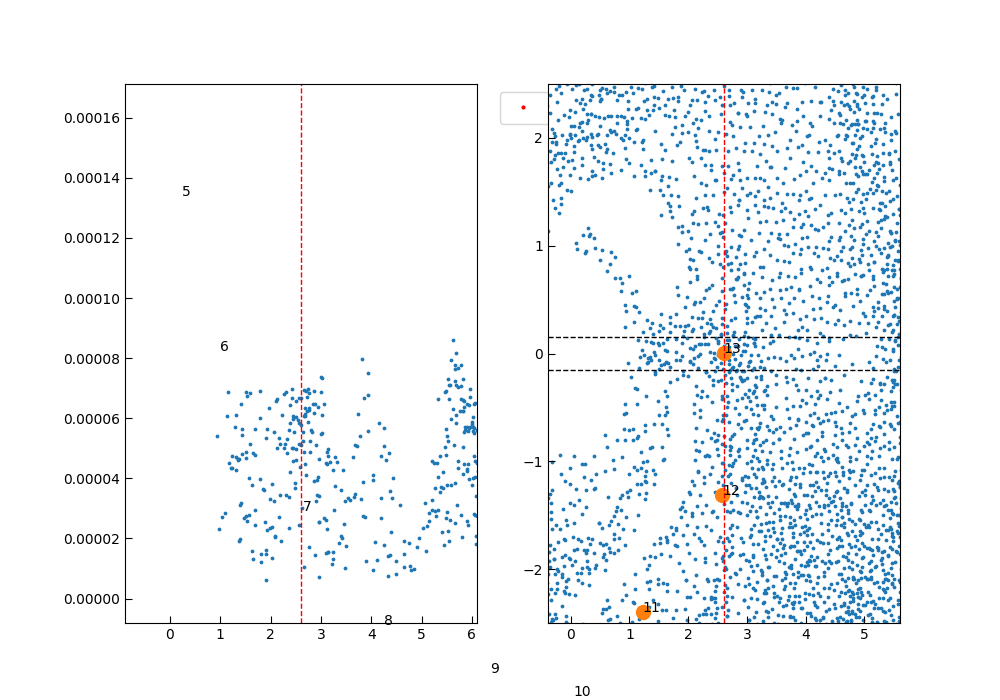

In [317]:
n= 13 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-3.5,x_tracing+3.5)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [318]:
dict_lims = klicker.get_positions()
#print(dict_lims)}

In [319]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(2.5101140116823924e-07, 6.782882476450397e-05)

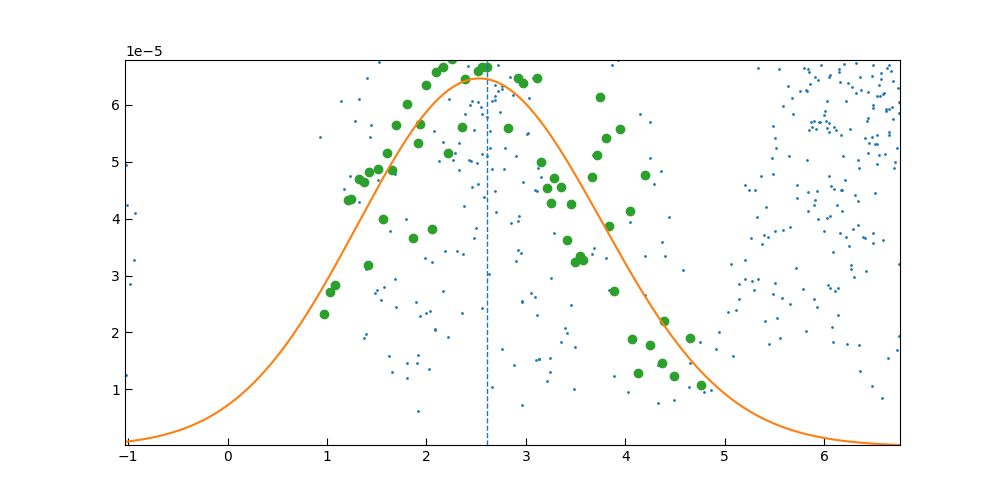

In [320]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [321]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [322]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000203,12.463550,0.05,False,-2.815769,0.0,0.943725,0.000016,0.072555,1.461911,0.155144,"[10.262399426064238, 10.37397427238432, 10.455...",10.728716,"[7.114439416696633e-06, 2.707541376557573e-05,...",-6.094877
1,0.000141,11.975673,0.05,False,-3.366697,1.0,1.562937,0.000020,0.178578,3.184783,0.243040,"[9.086654767552309, 9.309088161549216, 9.34395...",9.805195,"[9.727255496254541e-06, 1.563181236322171e-05,...",-4.363276
2,0.000130,8.261321,0.05,False,2.006645,2.0,1.549316,0.000016,0.253238,2.675818,0.505752,"[8.33647810734634, 8.399783145840232, 8.421192...",9.112554,"[2.9591431342449587e-05, 4.0530314755379685e-0...",-2.516234
3,0.000152,7.897388,0.05,False,13.163369,3.0,1.869078,0.000021,0.039155,7.724921,0.346563,"[6.592525474449446, 6.72636676352982, 7.829998...",8.304473,"[6.545554479324e-06, 9.364813303542908e-06, 2....",-1.304113
4,0.000135,7.338870,0.05,False,3.730706,4.0,1.011652,0.000011,0.057147,1.660502,0.135700,"[7.025014720307014, 7.158976370716165, 7.19647...",7.784993,"[1.094205235915336e-05, 3.7773963100443755e-05...",0.023449
5,0.000083,6.883319,0.05,False,-2.837180,5.0,0.656595,0.000015,0.065348,1.681482,0.201961,"[5.666223254444301, 6.325729257305872, 6.41201...",6.457431,"[1.277708633521095e-05, 7.986502030181522e-05,...",2.043651
6,0.000144,5.113400,0.05,False,2.476957,6.0,1.299634,0.000009,0.125052,1.195378,0.178994,"[4.547649299586324, 4.611009611120109, 4.66550...",5.187590,"[9.850522383556322e-06, 2.2686173708823034e-05...",2.967172
7,0.000168,2.674620,0.05,False,4.289521,7.0,2.353237,0.000021,0.150712,3.037002,0.537838,"[2.332397475528512, 2.4764004599370324, 2.5243...",3.225108,"[1.3769220909510435e-05, 2.842521436307109e-05...",3.544372
8,0.000154,3.850712,0.05,False,-1.223236,8.0,1.369965,0.000014,0.685891,1.940041,0.696616,"[1.6680872096442332, 1.7653030374194496, 1.834...",1.493506,"[2.2616108361426645e-05, 2.1530863874604127e-0...",3.775253
9,0.000162,2.606378,0.05,False,0.003659,9.0,1.113753,0.000009,61129.206318,68790.204664,179.198702,"[1.0773000888566264, 1.1222088877236285, 1.150...",-0.295815,"[3.473598744136872e-05, 4.1518993158277757e-05...",3.255772


In [323]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 0.000199224
center                                                        1.96393
delta                                                            0.05
fractured                                                       False
gamma                                                        0.656215
id_tracing                                                         13
sigma                                                         1.37111
stderr_amplitude                                           8.1961e-06
stderr_center                                                 1.32952
stderr_gamma                                                  1.87711
stderr_sigma                                                 0.662523
x                   [0.9685879313863149, 1.0255939037611443, 1.085...
x_tracing                                                     -2.2583
y                   [2.319526892146993e-05, 2.7021902019902427e-05...
y_tracing           

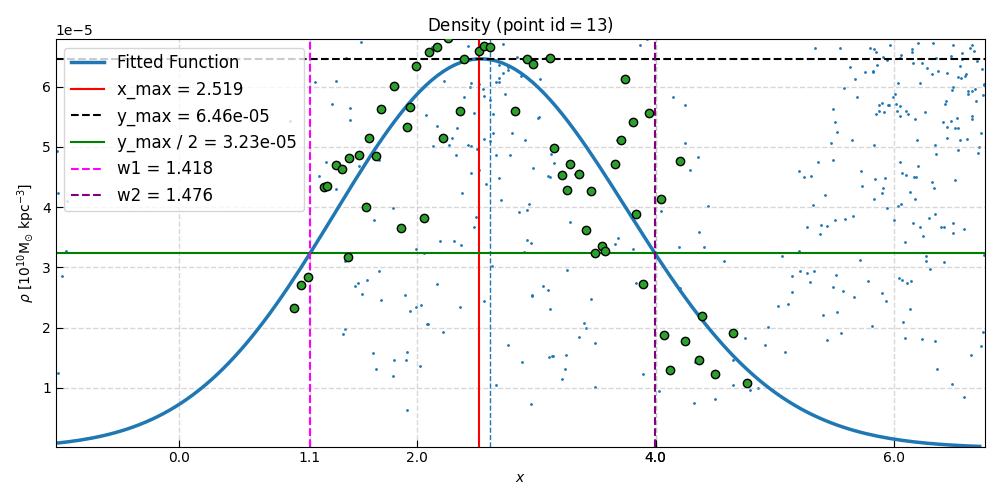

In [324]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

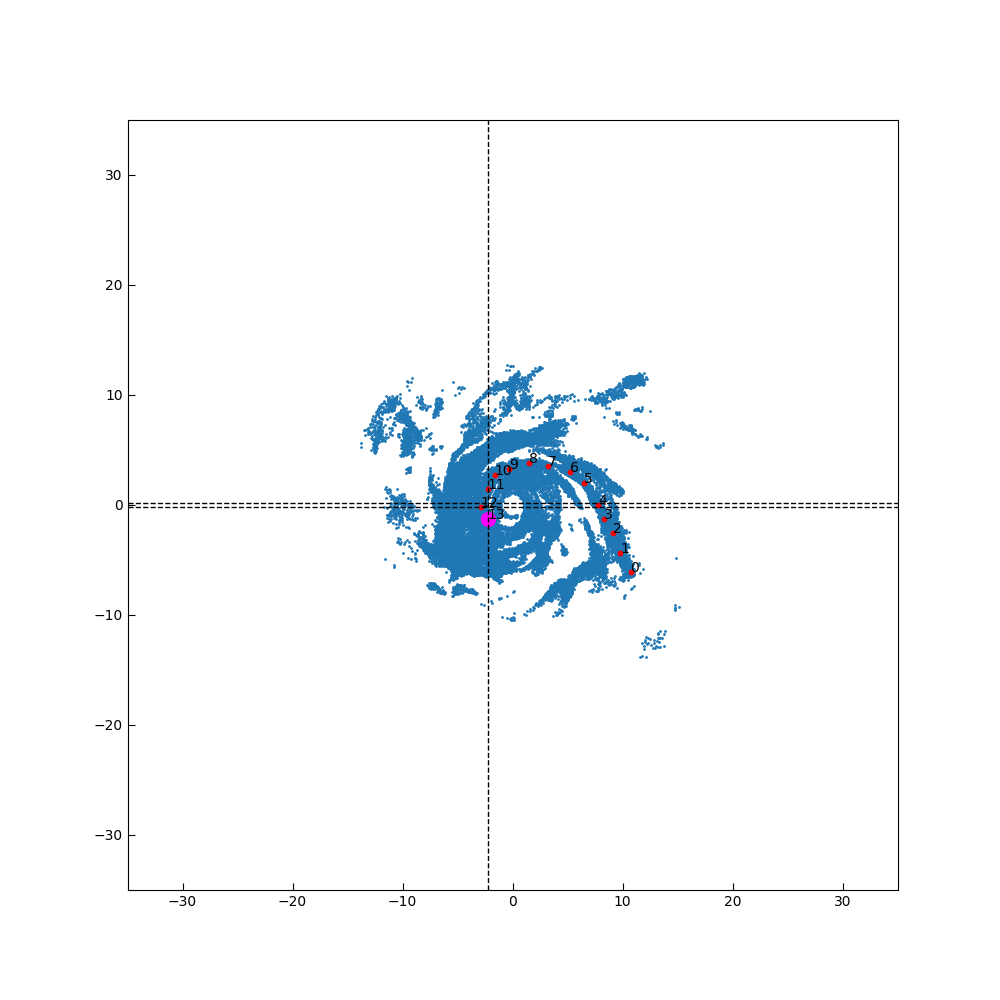

In [325]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 35
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [326]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')